In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Background

### In this work we want to use the time smartphones take to process requests from ipv6 protocols as their fingerprints, then use these fingerprints as a source of authentication, instead of trusting on credentials that can be more easily forged.

### **Section 2: Raw Dataset** Using a laptop, we generated IPv6 packets that smartphones must promptly respond, and measured the time between request and response, the Tound Trip Time (RTT), along with the time between consecutive responses, the Inter-Arrival Time (IAT). We created two datasets from these raw samples in CSV format: rtt.csv and iat.csv.

### **Section 3: Data Analysis** We then analysed how RTTs and IATs of multiple devices look like. From analysis of these plots and insights during experiments, we noticed two things: both RTT and IAT datasets contain outliers with high values that strongly differ from the mean and must be dropped from the final dataset; eventually responses for RTTs are duplicated by the network and cause samples with very small values that must be dropped from the final dataset.

### **Section 4: Looking for features** We analyzed how aggregation of RTTs and IATs develop over time with an increasing number of samples. From this analysis, we noticed that aggregation of thousands of RTTs or dozens of IATs tend to converge to values that are noticeably different among different devices.

### **Section 5: Feature-rich dataset** From analysis described in Sections 3 and 4, we created a dataset from aggregation of 6000 consecutive RTTs and 100 consecutive IATs, dropping super-small RTTs caused by spare packet duplication, resulting in 700 samples (50 samples per device), with the following features per device: min_rtt, max_rtt, mean_rtt, median_rtt, min_iat, max_iat, mean_iat, median_iat. Since values are very small, we think computing polynomial features from a combination among these features can exarcebate the differences among devices and help machine learning models, but this is letft as a work for a next step, when we begin to experiment with such models.

# 1. Utility code for manipulation of files with raw data (RTT and IAT)

In [4]:
DEVICES_DATA_DIR = "../agent/data"
pd.set_option('precision', 9)

In [5]:
def get_devices_list():
    """Returns a list of device names in ipv6 format"""
    for _, dirs, _ in os.walk(DEVICES_DATA_DIR):
        return dirs

# 2. Datasets of RTTs and IATs

In [6]:
def read_samples(device, device_id, sample_type):
    """Returns all IATs or RTTs of a device as a pandas dataframe

    Example of a dataframe returned by this function with sample_type="rtt":
    | device |  rtt  |
    |    0   | 0.003 |
    |    0   | 0.001 |

    Parameters:
    device (str): Device name in ipv6 format
    device_id (int): Device unique identifier
    sample_type (str): Sample type can be either 'rtt' or 'iat'

    Returns:
    pandas.DataFrame:Pandas dataframe with samples associated to a device id
    """
    filename = f"{DEVICES_DATA_DIR}/{device}/{sample_type}.txt"
    
    measurements = None
    with open(filename) as f:
        lines = np.array(f.read().splitlines())
        measurements = lines.astype(float)

    df = pd.DataFrame(data=measurements, columns=[sample_type])
    df["device"] = device_id
    return df

def build_raw_dataset(devices, sample_type):
    """ Generates and saves a dataset in CSV format containing RTTs or IATs of all devices

    First, we build a pandas dataframe with all devices in the format below:
    
    | device |  rtt  | device |  rtt  |
    |    0   | 0.003 |        |       |
    |    0   | 0.001 |        |       |
                     |    1   | 0.002 |
                     |    1   | 0.004 |

    Then, we concatenate rows to make the resulting dataframe like presented below:
    | device |  rtt  |
    |    0   | 0.003 |
    |    0   | 0.001 |
    |    1   | 0.002 |
    |    1   | 0.004 |

    Finally, we save the resulting dataframe as a csv file with name 'rtt.csv' or 'iat.csv.
    """
    
    samples = [read_samples(devices[i], i, sample_type) for i in range(len(devices))]
    samples = pd.concat(samples, axis=0, sort=True)
    samples.to_csv(f"{sample_type}.csv", sep=' ', float_format='%.9f', encoding='utf-8', index=False)

In [7]:
# Generate dataset of IATs and RTTs for all devices
devices = get_devices_list()
sample_types = ["rtt", "iat"]
    
for sample_type in sample_types:
    build_raw_dataset(devices, sample_type)

# 3. Initial data analysis

## 3.1 Read datasets of IATs and RTTs

In [8]:
# Read dataset of raw RTT and IAT samples
rtt = pd.read_csv("rtt.csv", delimiter=" ", dtype=np.float64)
iat = pd.read_csv("iat.csv", delimiter=" ", dtype=np.float64)

In [9]:
# Get list of device IDs
devices = pd.unique(rtt["device"])
print(devices)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


## 3.2. Plot RTT samples of each device

Text(0.5, 1.0, 'ROUND TRIP TIME')

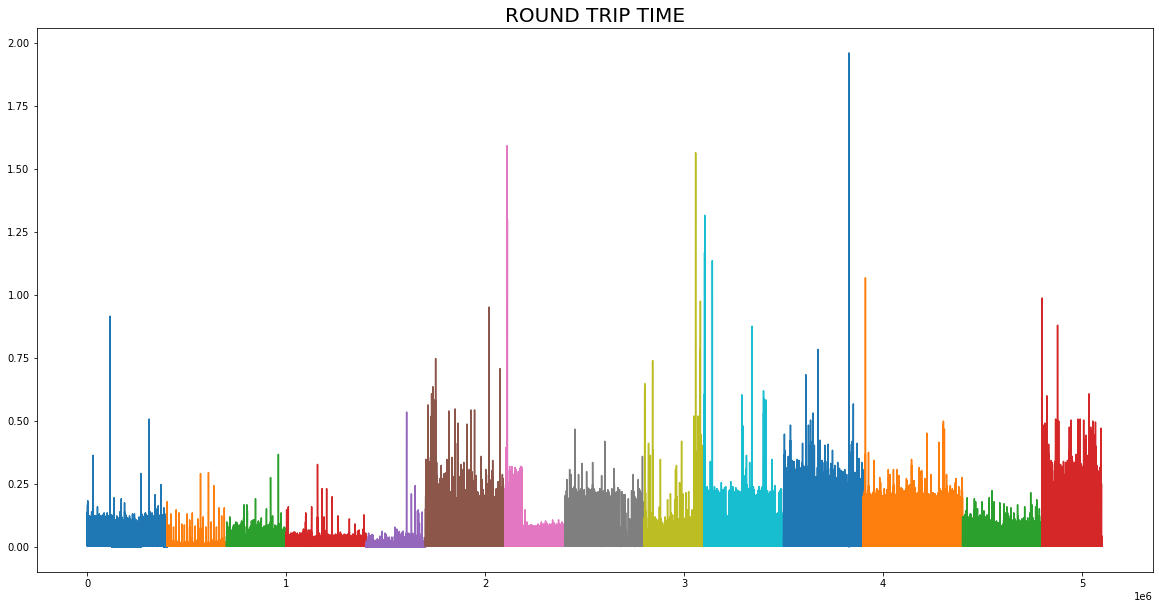

In [10]:
plt.figure(figsize=(20,10))
for device in devices:
    d = rtt[rtt["device"] == device]
    plt.plot(d["rtt"])

plt.title("ROUND TRIP TIME", fontsize=20)

## 3.3. IAT samples of each device

(0.0, 0.0001)

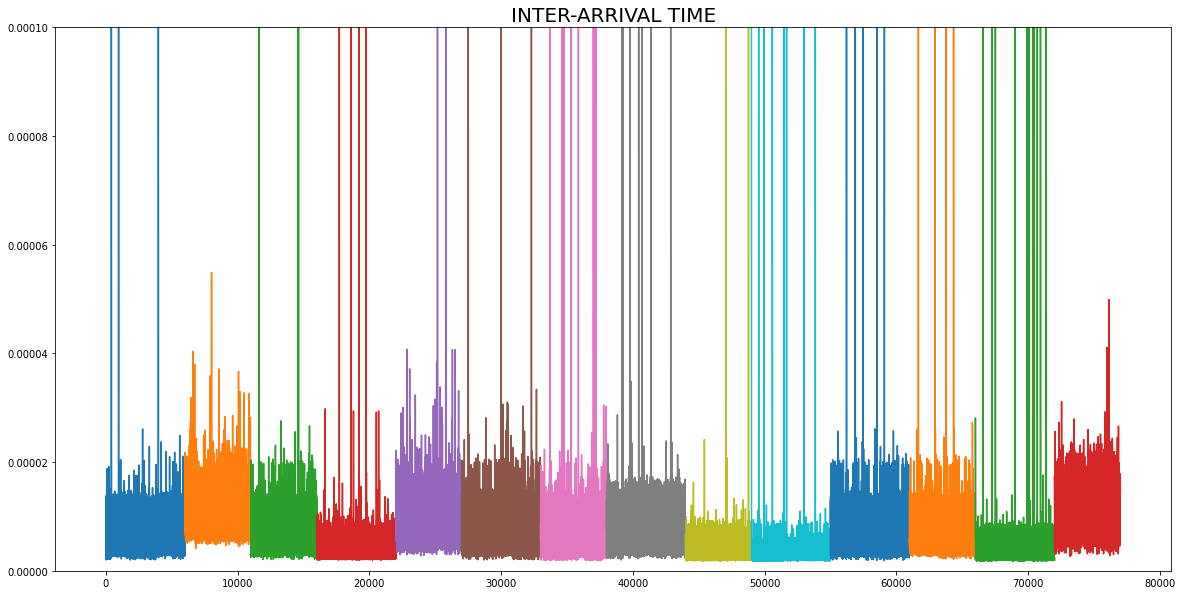

In [11]:
plt.figure(figsize=(20,10))
for device in devices:
    d = iat[iat["device"] == device]
    plt.plot(d["iat"])
    
plt.title("INTER-ARRIVAL TIME", fontsize=20)
plt.ylim((0,0.0001))

# 4. How aggregation of IATs and RTTs evolve over time

In [12]:
def aggregate(rtts, iats, range_rtts, range_iats, aggregation_function):
    agg_rtt_vals = {}
    agg_iat_vals = {}

    for device in devices:
        agg_rtt_vals[device] = []
        agg_iat_vals[device] = []

    for device in devices:
        dev_rtts = rtt[rtt["device"] == device]
        dev_iats = iat[iat["device"] == device]
        
        for i in range_rtts:
            agg_rtt_vals[device].append(aggregation_function(dev_rtts["rtt"][0:i]))

        for i in range_rtts:
            agg_iat_vals[device].append(aggregation_function(dev_iats["iat"][0:i]))
    return agg_rtt_vals, agg_iat_vals

## 4.1 Minimum of RTT and IAT (all devices)

In [13]:
min_rtt_vals, min_iat_vals = aggregate(iat, rtt, range(10, 6000), range(10, 100), np.min)

(0.00385, 0.004)

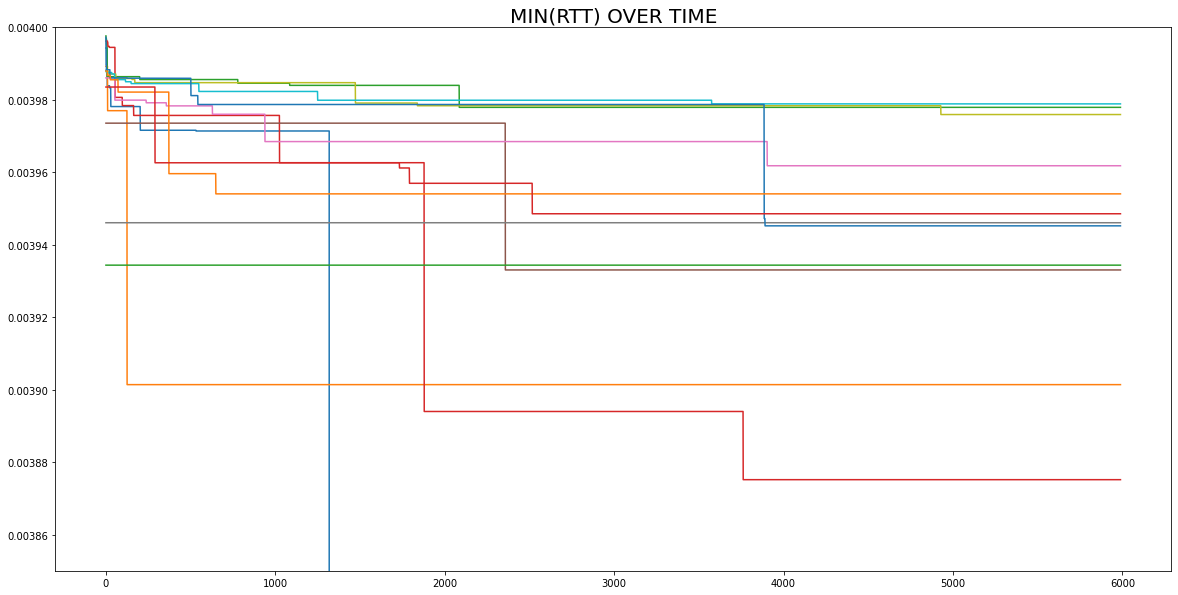

In [14]:
# PLOT MIN RTT
plt.figure(figsize=(20,10))
for device in devices:
    plt.plot(min_rtt_vals[device])
plt.title("MIN(RTT) OVER TIME", fontsize=20)
plt.ylim((0.00385, 0.004))

Text(0.5, 1.0, 'MIN(IAT) OVER TIME')

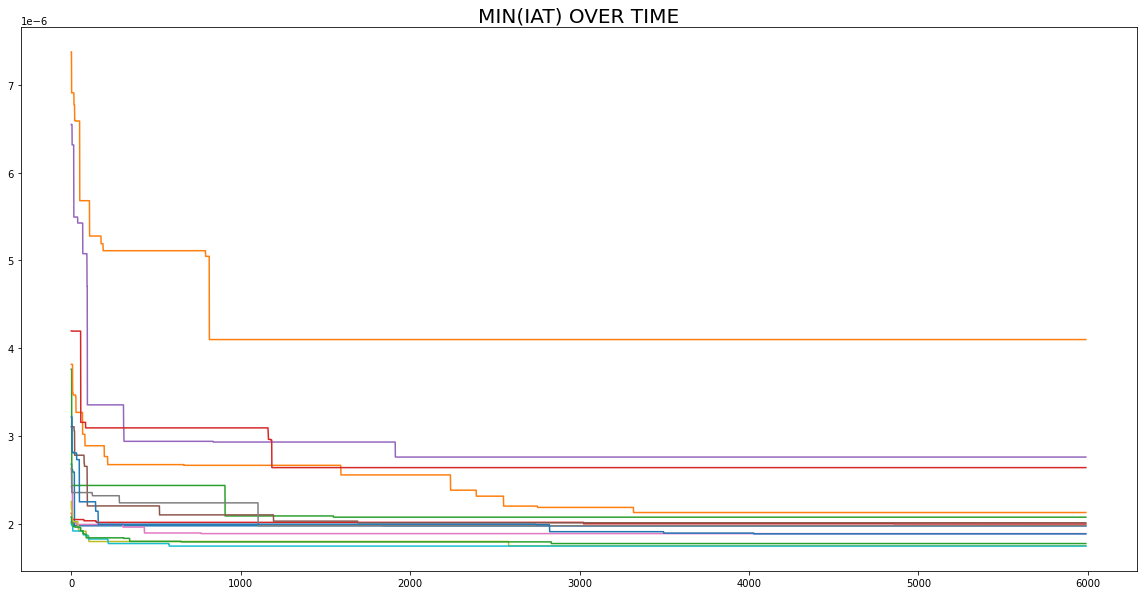

In [15]:
# PLOT MIN IAT
plt.figure(figsize=(20,10))
for device in devices:
    plt.plot(min_iat_vals[device])
plt.title("MIN(IAT) OVER TIME", fontsize=20)

## 4.2 Maximum of RTT and IAT (all devices)

In [16]:
max_rtt_vals, max_iat_vals = aggregate(iat, rtt, range(10, 6000), range(10, 100), np.max)

Text(0.5, 1.0, 'MAX(RTT) OVER TIME')

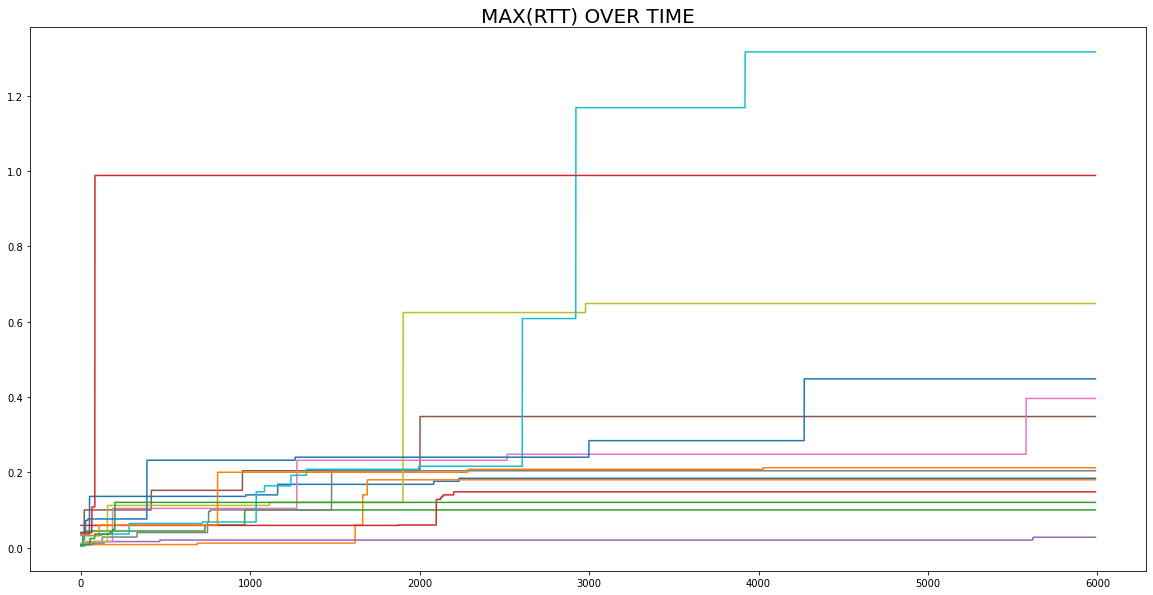

In [17]:
# PLOT MIN RTT
plt.figure(figsize=(20,10))
for device in devices:
    plt.plot(max_rtt_vals[device])
plt.title("MAX(RTT) OVER TIME", fontsize=20)

Text(0.5, 1.0, 'MAX(IAT) OVER TIME')

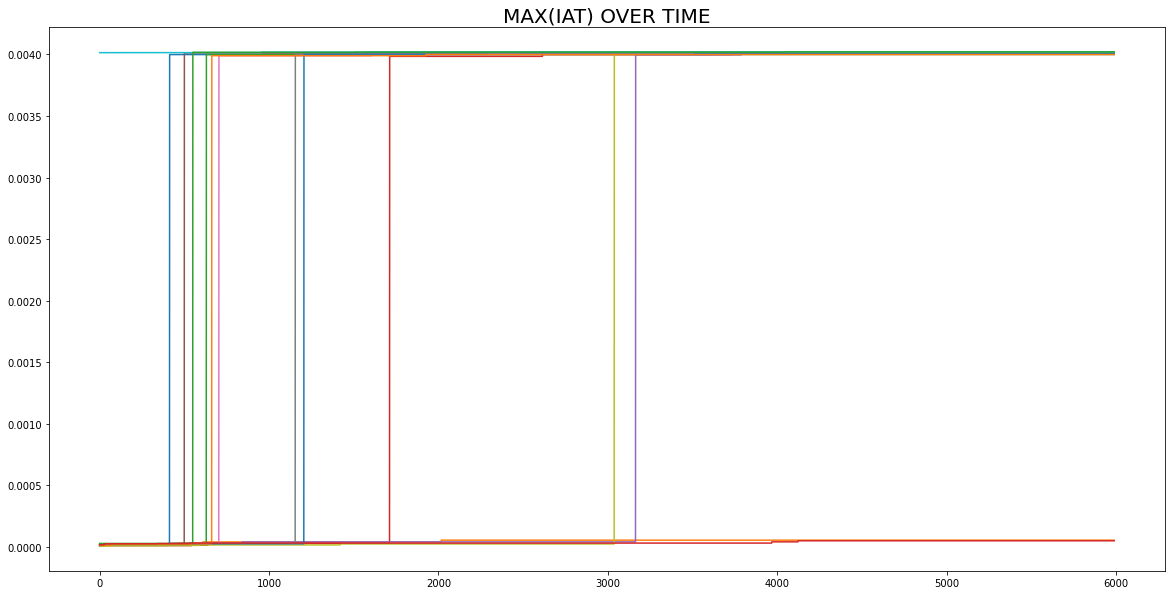

In [18]:
# PLOT MAX IAT
plt.figure(figsize=(20,10))
for device in devices:
    plt.plot(max_iat_vals[device])
plt.title("MAX(IAT) OVER TIME", fontsize=20)

## 4.3 Mean of RTT and IAT (all devices)

In [19]:
mean_rtt_vals, mean_iat_vals = aggregate(iat, rtt, range(10, 6000), range(10, 100), np.mean)

Text(0.5, 1.0, 'MEAN(RTT) OVER TIME')

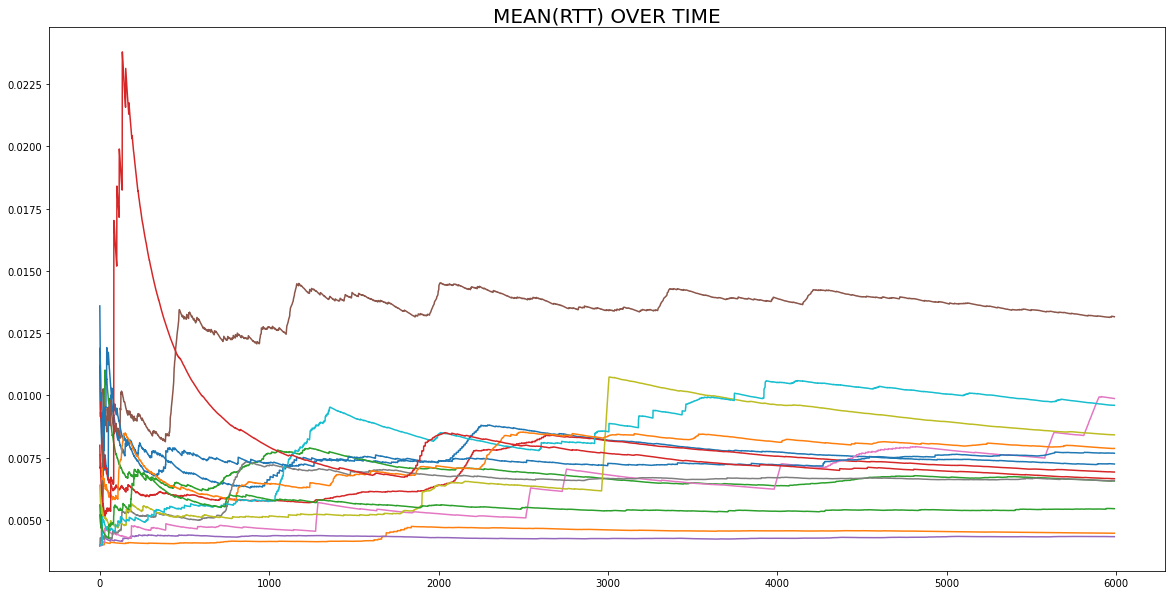

In [20]:
# PLOT MEAN RTT
plt.figure(figsize=(20,10))
for device in devices:
    plt.plot(mean_rtt_vals[device])
plt.title("MEAN(RTT) OVER TIME", fontsize=20)

(0.0, 2e-05)

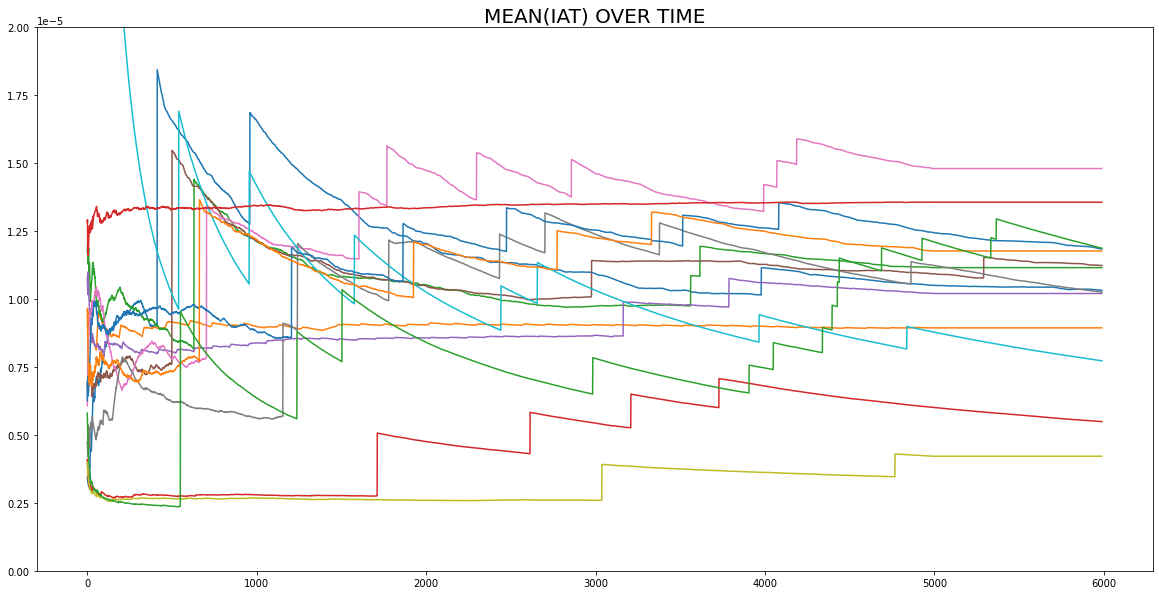

In [21]:
# PLOT MEAN IAT
plt.figure(figsize=(20,10))
for device in devices:
    plt.plot(mean_iat_vals[device])
plt.title("MEAN(IAT) OVER TIME", fontsize=20)
plt.ylim((0.0, 0.00002))

## 4.4 Median of RTT and IAT (all devices)

In [22]:
median_rtt_vals, median_iat_vals = aggregate(iat, rtt, range(10, 6000), range(10, 100), np.median)

(0.003988, 0.004004)

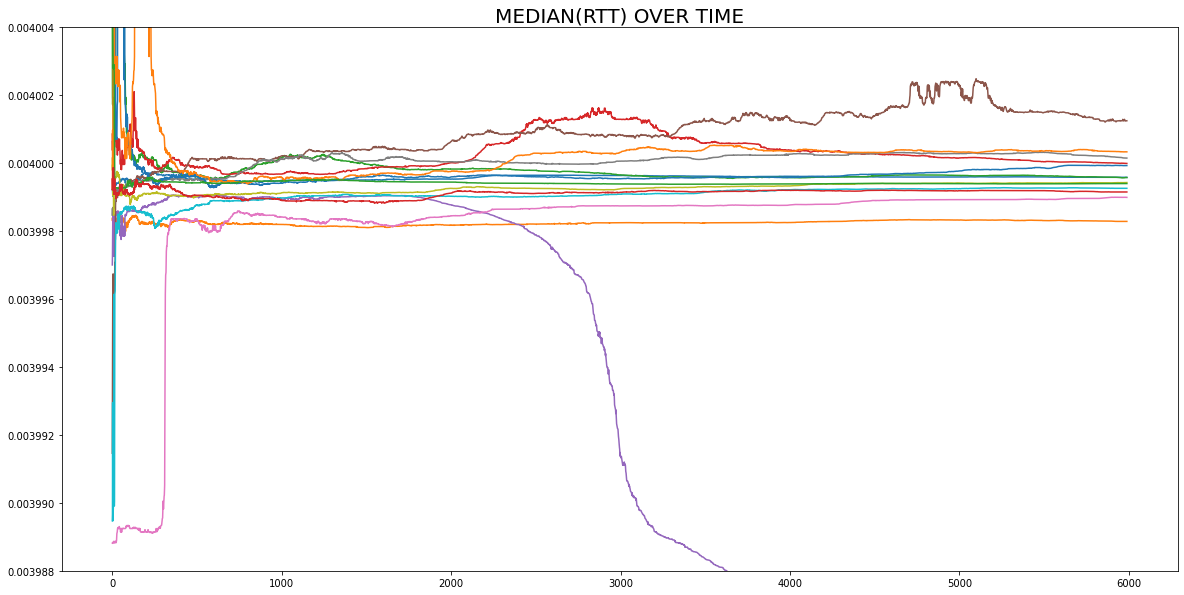

In [23]:
# PLOT MEDIAN RTT
plt.figure(figsize=(20,10))
for device in devices:
    plt.plot(median_rtt_vals[device])
plt.title("MEDIAN(RTT) OVER TIME", fontsize=20)
plt.ylim((0.003988, 0.004004))

Text(0.5, 1.0, 'MEDIAN(IAT) OVER TIME')

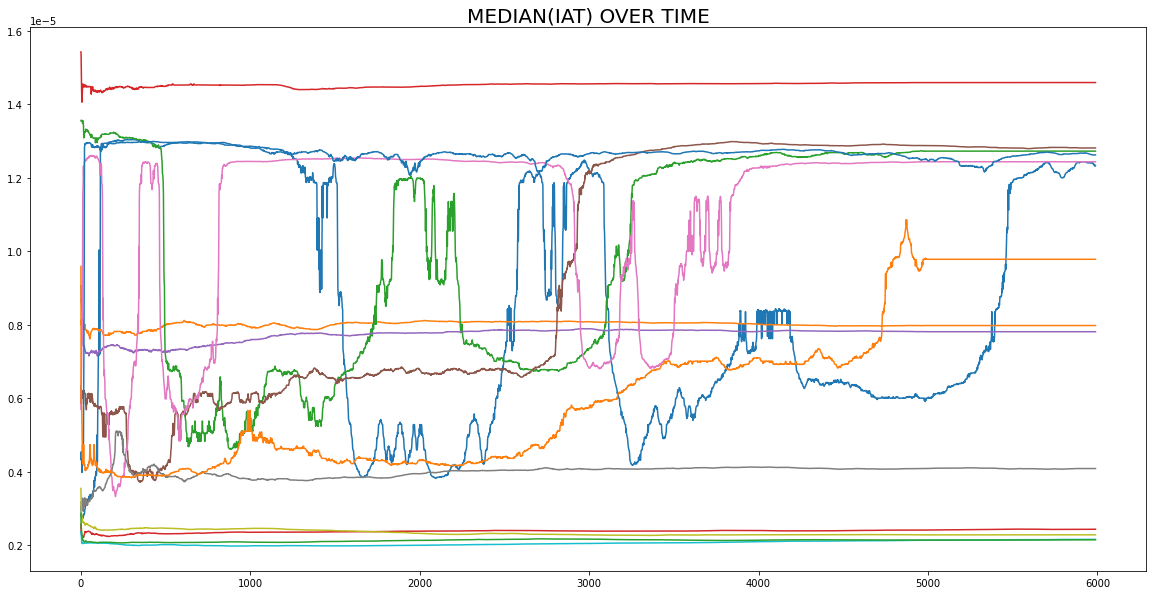

In [24]:
# PLOT MEDIAN IAT
plt.figure(figsize=(20,10))
for device in devices:
    plt.plot(median_iat_vals[device])
plt.title("MEDIAN(IAT) OVER TIME", fontsize=20)

# 5. Make dataset by aggregating multiple IATs and RTTs (min, max, mean, median)

In [30]:
'''
Values below exist to guarantee that we have the same number of samples for all devices,
and that each sample is computed from the same ammount of data.
'''
# Use (6000, 100) or (3000, 50)
SAMPLE_SIZE_RTT = 3000 # Number of RTTs used to compute each aggregated sample of the dataset.
SAMPLE_SIZE_IAT = 50  # Number of IATs used to compute each aggregated sample of the dataset.

MAX_RTT = 300000       # How many RTTs we want to use to compute all aggregated samples
MAX_IAT = 5000         # How many IATs we want to use to compute all aggregated samples

#TODO: Improve readability of this function.
def aggregate_samples(device, samples_type, samples):
    # Address when neighbor Sol/Adv are doubled, causing very small RTT
    if (samples_type == "rtt"):
        condition = samples > 0.000010000
        samples = np.extract(condition, samples)
        
        max_rtts = MAX_RTT

        if len(samples) < max_rtts:
            print("Not enough RTTs")
            sys.exit(1)
        samples = samples[0:max_rtts]
        tail = len(samples) % SAMPLE_SIZE_RTT
        sample_size = SAMPLE_SIZE_RTT
    elif samples_type == "iat":
        max_iats = MAX_IAT

        if len(samples) < max_iats:
            print("Not enough IATs")
            sys.exit(1)
        samples = samples[0:max_iats]
        tail = len(samples) % SAMPLE_SIZE_IAT
        sample_size = SAMPLE_SIZE_IAT
    else:
        print("Unknown measure: ", samples_type)
        sys.exit(1)

    # Guaranteeing splits are of equal size
    if tail > 0:
        samples = samples[0:len(samples)-tail]

    num_samples = len(samples)/sample_size
    samples_subset = np.split(samples, num_samples)
    
    df = pd.DataFrame(columns=["max_" + samples_type, "min_" + samples_type, 
                               "mean_" + samples_type, "median_" + samples_type])

    for i in range(len(samples_subset)):
        median = np.median(samples_subset[i])
        minimum = np.min(samples_subset[i])
        maximum = np.max(samples_subset[i])
        mean = np.mean(samples_subset[i])
        
        df.loc[i] = [maximum, minimum, mean, median]
    
    return df

# Each measurement is an RTT value, for example.
def compute_features(device, samples_type):
    filename = f"{DEVICES_DATA_DIR}/{device}/{samples_type}.txt"
    
    with open(filename) as f:
        lines = np.array(f.read().splitlines())
        samples = lines.astype(float)
    
    return aggregate_samples(device, samples_type, samples)

def compute_device_features(device, device_id):
    print("Device {} as {}".format(device, device_id))
    samples_types = ["rtt", "iat"]
    
    features = [compute_features(device, samples_type) for samples_type in samples_types]
    features = pd.concat(features, axis=1)

    features["device"] = device_id
    
    return features

def build_features_dataset(devices):
    features_per_device = [compute_device_features(devices[i], i) for i in range(len(devices))]
    features = pd.concat(features_per_device, axis=0, sort=True) # merge rows
    features = features.fillna(0)
    
    features.to_csv("dataset.csv", sep=' ', float_format='%.9f', encoding='utf-8', index=False)

In [31]:
# Generate dataset of aggregated samples containing: 
# minRTT, minIAT, meanRTT, meanIAT, medianRTT, medianIAT, maxRTT and maxIAT

devices = get_devices_list()
build_features_dataset(devices)

Device fe80::4a60:5fff:fe74:1b87 as 0
Device fe80::ae37:43ff:fe0f:6d79 as 1
Device fe80::d277:14ff:fe65:cf93 as 2
Device fe80::aa16:d0ff:fe69:3491 as 3
Device fe80::5eaf:6ff:fe2d:d81b as 4
Device fe80::9ad6:f7ff:feed:78c1 as 5
Device fe80::6ac4:4dff:fee7:f9f2 as 6
Device fe80::4288:5ff:feb3:bc06 as 7
Device fe80::36bb:26ff:fe61:8125 as 8
Device fe80::ae37:43ff:fee0:b41c as 9
Device fe80::d2e6:2e92:1999:d5fd as 10
Device fe80::8e45:ff:feb3:639f as 11
Device fe80::7a4b:87ff:fe6a:ed9e as 12
Device fe80::4680:ebff:fec0:56 as 13
